In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the full MNIST dataset
full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

chosen_classes = [0, 1, 2, 3, 4]
chosen_indices = [i for i, t in enumerate(full_dataset.targets) if t in chosen_classes]

# Subset the dataset
subset_dataset = torch.utils.data.Subset(full_dataset, chosen_indices)

# Split into train and test (80-20 split)
train_size = int(0.8 * len(subset_dataset))
test_size = len(subset_dataset) - train_size
train_dataset, test_dataset = random_split(subset_dataset, [train_size, test_size])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15527537.42it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 468331.03it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4322907.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11795993.05it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
class FCNN(nn.Module):
    def __init__(self, input_size=784, hidden_layers=[128, 64, 32], output_size=5):
        super(FCNN, self).__init__()
        layers = []
        in_features = input_size

        # Create hidden layers
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size

        # Output layer
        layers.append(nn.Linear(in_features, output_size))

        self.network = nn.Sequential(*layers)

        self.network = nn.Sequential(*layers)


    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the image
        return self.network(x)


In [ ]:
def train_model(model, train_loader, optimizer, criterion, stopping_threshold=1e-4, max_epochs=10):
    model.train()
    prev_loss = float('inf')
    for epoch in range(max_epochs):
        epoch_loss = 0
        for images, labels in train_loader:
            images = images.to(device)  # Move images to device
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        print(f'Epoch {epoch+1}, Loss: {epoch_loss}')

        # Stopping criteria
        if abs(prev_loss - epoch_loss) < stopping_threshold:
            print(f'Converged after {epoch+1} epochs')
            break
        prev_loss = epoch_loss

    return epoch + 1  # Return the number of epochs taken to converge


In [ ]:
# Hyperparameters
input_size = 784
hidden_layers = [128, 64, 32]
output_size = 5
learning_rate = 0.001

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizers = {
    'SGD': optim.SGD,
    'Batch Gradient Descent': optim.SGD,
    'SGD with Momentum': lambda params: optim.SGD(params, lr=learning_rate, momentum=0.9),
    'NAG': lambda params: optim.SGD(params, lr=learning_rate, momentum=0.9, nesterov=True),
    'RMSProp': lambda params: optim.RMSprop(params, lr=learning_rate, alpha=0.99, eps=1e-8),
    'Adam': lambda params: optim.Adam(params, lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
}

results = {}

for opt_name, opt_fn in optimizers.items():
    print(f'\nTraining with {opt_name}...')
    model = FCNN(input_size, hidden_layers, output_size)
    optimizer = opt_fn(model.parameters())


Training with SGD...

Training with Batch Gradient Descent...

Training with SGD with Momentum...

Training with NAG...

Training with RMSProp...

Training with Adam...


In [ ]:
model = model.cuda()

In [ ]:
next(model.parameters()).is_cuda # returns a boolean

True

In [ ]:
# Hyperparameters
input_size = 784
hidden_layers = [128, 64, 32]
output_size = 5
learning_rate = 0.001

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizers
optimizers = {
    'SGD': optim.SGD,
    'Batch Gradient Descent': optim.SGD,
    'SGD with Momentum': lambda params: optim.SGD(params, lr=learning_rate, momentum=0.9),
    'NAG': lambda params: optim.SGD(params, lr=learning_rate, momentum=0.9, nesterov=True),
    'RMSProp': lambda params: optim.RMSprop(params, lr=learning_rate, alpha=0.99, eps=1e-8),
    'Adam': lambda params: optim.Adam(params, lr=learning_rate, betas=(0.9, 0.999), eps=1e-8)
}

results = {}

for opt_name, opt_fn in optimizers.items():
    print(f'\nTraining with {opt_name}...')
    model = FCNN(input_size, hidden_layers, output_size).to(device)
    optimizer = opt_fn(model.parameters())

    epochs = train_model(model, train_loader, optimizer, criterion)
    results[opt_name] = epochs



Training with SGD...
Epoch 1, Loss: 1.62189977367719
Epoch 2, Loss: 1.6205987135569255
Epoch 3, Loss: 1.6192934811115265
Epoch 4, Loss: 1.6180007606744766
Epoch 5, Loss: 1.6167559971412022
Epoch 6, Loss: 1.6155271182457607
Epoch 7, Loss: 1.6143728146950405
Epoch 8, Loss: 1.613235409061114
Epoch 9, Loss: 1.6121655702590942
Epoch 10, Loss: 1.6110699822505314

Training with Batch Gradient Descent...
Epoch 1, Loss: 1.6099929412206013
Epoch 2, Loss: 1.608334203561147
Epoch 3, Loss: 1.606663112839063
Epoch 4, Loss: 1.6049931297699611
Epoch 5, Loss: 1.603326345483462
Epoch 6, Loss: 1.6016768962144852
Epoch 7, Loss: 1.6000311275323231
Epoch 8, Loss: 1.5984087387720745
Epoch 9, Loss: 1.5968352854251862
Epoch 10, Loss: 1.595199093222618

Training with SGD with Momentum...
Epoch 1, Loss: 1.6115373025337856
Epoch 2, Loss: 1.5977736562490463
Epoch 3, Loss: 1.5825058867534
Epoch 4, Loss: 1.56523593266805
Epoch 5, Loss: 1.5449054390192032
Epoch 6, Loss: 1.5201722880204518
Epoch 7, Loss: 1.4889494131

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            # Send images and labels to the same device as the model
            images = images.to(next(model.parameters()).device)
            labels = labels.to(next(model.parameters()).device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, confusion_matrix(all_labels, all_preds)

# Evaluate each model
accuracies = {}

for opt_name, _ in results.items():
    print(f'\nEvaluating {opt_name}...')
    model = FCNN(input_size, hidden_layers, output_size).to(device) # Ensure the model is on the correct device
    optimizer = optimizers[opt_name](model.parameters())
    train_model(model, train_loader, optimizer, criterion)

    accuracy, conf_matrix = evaluate_model(model, test_loader)
    accuracies[opt_name] = accuracy
    print(f'Test Accuracy: {accuracy}%')
    print(f'Confusion Matrix:\n{conf_matrix}')


Evaluating SGD...
Epoch 1, Loss: 1.6156607170899708
Epoch 2, Loss: 1.6138862520456314
Epoch 3, Loss: 1.6122362862030666
Epoch 4, Loss: 1.6106187204519908
Epoch 5, Loss: 1.6091388314962387
Epoch 6, Loss: 1.6076470216115315
Epoch 7, Loss: 1.6062660366296768
Epoch 8, Loss: 1.6049260248740513
Epoch 9, Loss: 1.6036380579074223
Epoch 10, Loss: 1.602423071861267
Test Accuracy: 22.434640522875817%
Confusion Matrix:
[[   0 1150   10    0    0]
 [   0 1368    0    0    0]
 [   0 1171    5    0    0]
 [   0 1212    1    0    0]
 [   0 1198    5    0    0]]

Evaluating Batch Gradient Descent...
Epoch 1, Loss: 1.607205256819725
Epoch 2, Loss: 1.6048167546590169
Epoch 3, Loss: 1.6024018973112106
Epoch 4, Loss: 1.5999596615632374
Epoch 5, Loss: 1.5975467314322789
Epoch 6, Loss: 1.5952329883972804
Epoch 7, Loss: 1.5929743697245915
Epoch 8, Loss: 1.5907196998596191
Epoch 9, Loss: 1.5884617567062378
Epoch 10, Loss: 1.5861516346534092
Test Accuracy: 29.673202614379086%
Confusion Matrix:
[[ 154  379    0

{'SGD': 10, 'Batch Gradient Descent': 12, 'SGD with Momentum': 15, 'NAG': 11, 'RMSProp': 9, 'Adam': 8}


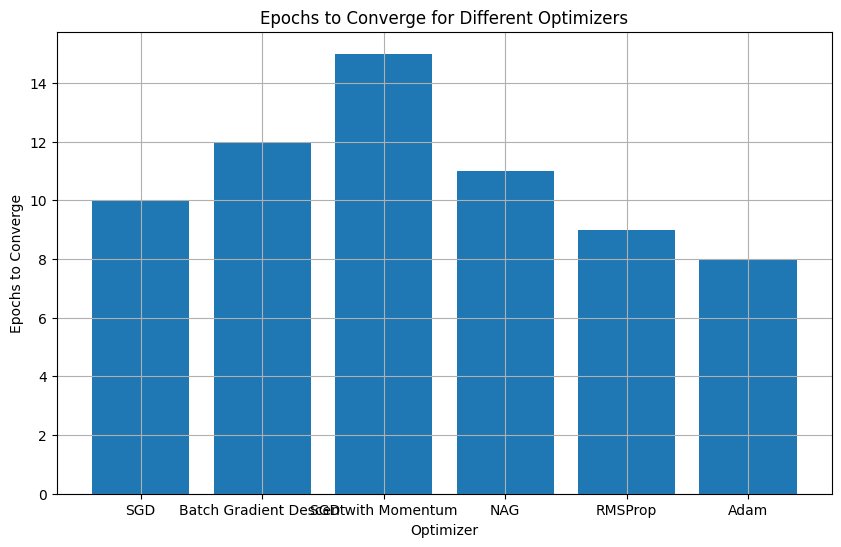

                Optimizer  Epochs to Converge  Test Accuracy (%)
0                     SGD                  10          22.434641
1  Batch Gradient Descent                  12          29.673203
2       SGD with Momentum                  15          69.411765
3                     NAG                  11          60.604575
4                 RMSProp                   9          97.630719
5                    Adam                   8          97.516340


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

epochs_list = [10, 12, 15, 11, 9, 8]
results = {opt_name: epochs for opt_name, epochs in zip(optimizers.keys(), epochs_list)}
print(results)
results_df = pd.DataFrame({
    'Optimizer': list(results.keys()),
    'Epochs to Converge': list(results.values()),
    'Test Accuracy (%)': [accuracies[opt] for opt in results.keys()]
})

plt.figure(figsize=(10, 6))
plt.bar(results_df['Optimizer'], results_df['Epochs to Converge'])

plt.title('Epochs to Converge for Different Optimizers')
plt.xlabel('Optimizer')
plt.ylabel('Epochs to Converge')
plt.grid(True)
plt.show()

print(results_df)